In [1]:
import os

from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import binary_dilation, disk
from skimage.measure import regionprops_table
from sklearn.mixture import GaussianMixture
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc



import sys
sys.path.append("..")
from src.dataset import TileImg2ImgSlideDataset

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# From Downloaded Data

In [ ]:
import shutil


ORIG_HEMIT_DATASET = Path("").resolve()
HEMIT_NUCLEI_DATASET = Path("").resolve()

dataframe_dict = {}
for phase in ["train", "val", "test"]:
    download_nuclei_dir = HEMIT_NUCLEI_DATASET / phase / "mask"
    nuclei_dir = ORIG_HEMIT_DATASET / phase / "mask"
    shutil.copytree(download_nuclei_dir, nuclei_dir)
    download_csv_dir = HEMIT_NUCLEI_DATASET / phase / "csv"
    csv_dir = ORIG_HEMIT_DATASET / phase / "csv"
    shutil.copytree(download_csv_dir, csv_dir)

    dataframe_phase = pd.DataFrame(columns=["in_slide_name", "image_path", "target_path", "nuclei_path", "nuclei_csv_path"])
    image_dir = ORIG_HEMIT_DATASET / phase / "input"
    target_dir = ORIG_HEMIT_DATASET / phase / "label"
    dataframe_phase["image_path"] = sorted([str(fn) for fn in image_dir.glob("*.tif")])
    dataframe_phase["in_slide_name"] = dataframe_phase["image_path"].apply(lambda x: Path(x).name)
    dataframe_phase["target_path"] = dataframe_phase["in_slide_name"].apply(
        lambda x: str(target_dir / x))
    dataframe_phase["nuclei_path"] = dataframe_phase["in_slide_name"].apply(
        lambda x: str(nuclei_dir / x))
    dataframe_phase["nuclei_csv_path"] = dataframe_phase["in_slide_name"].apply(
        lambda x: str(csv_dir / x.replace(".tif", ".csv")))
    dataframe_dict[phase] = dataframe_phase

train_dataframe = dataframe_dict["train"]
val_dataframe = dataframe_dict["val"]
test_dataframe = dataframe_dict["test"]

slide_dataframe = pd.concat([train_dataframe, val_dataframe, test_dataframe], ignore_index=True)
slide_dataframe = slide_dataframe.drop(columns=["image_path", "target_path", "nuclei_path"])


train_dataframe.to_csv(ORIG_HEMIT_DATASET / "train_dataframe_hemit.csv", index=False)
val_dataframe.to_csv(ORIG_HEMIT_DATASET / "val_dataframe_hemit.csv", index=False)
test_dataframe.to_csv(ORIG_HEMIT_DATASET / "test_dataframe_hemit.csv", index=False)

slide_dataframe.to_csv(ORIG_HEMIT_DATASET / "slide_dataframe_hemit.csv", index=False)

# From Scratch

In [2]:
def normalize99(Y, x01, x99, copy=True):
    """
    Normalize the image so that 0.0 corresponds to the 1st percentile and 1.0 corresponds to the 99th percentile.

    Args:
        Y (ndarray): The input image (for downsample, use [Ly x Lx] or [Lz x Ly x Lx]).
        lower (int, optional): The lower percentile. Defaults to 1.
        upper (int, optional): The upper percentile. Defaults to 99.
        copy (bool, optional): Whether to create a copy of the input image. Defaults to True.
        downsample (bool, optional): Whether to downsample image to compute percentiles. Defaults to False.

    Returns:
        ndarray: The normalized image.
    """
    X = Y.copy() if copy else Y
    X = X.astype("float32") if X.dtype!="float64" and X.dtype!="float32" else X
    X -= x01 
    X /= (x99 - x01)
    return X

In [3]:
import cv2


def find_percentile_bin(histogram, percentile):
    """
    Find the bin index corresponding to the given percentile in a normalized histogram.
    
    Args:
    histogram (numpy.ndarray): The normalized histogram (sum equals 1).
    percentile (float): The desired percentile (0-100).
    
    Returns:
    int: The bin index corresponding to the percentile.
    """
    # Ensure the percentile is between 0 and 100
    if not 0 <= percentile <= 100:
        raise ValueError("Percentile must be between 0 and 100.")
    
    percentile_values = []
    for histogram_channel in histogram:
        # Calculate the cumulative distribution function (CDF)
        cdf = np.cumsum(histogram_channel)
        # Find the first index where the CDF value is greater than or equal to the percentile
        bin_index_channel = np.searchsorted(cdf, percentile, side='right')
        percentile_values.append(bin_index_channel)
    return np.asarray(percentile_values)

In [ ]:
DATASET_DIR = "" # Path to HEMIT Dataset Directory
DAPI_CKPT = "" # Path to Cellpose Ckpt file checkpoint
OUTPUT_DATAFRAME_DIR = ""


# Constants
MPP_HEMIT = 0.25
PADD_CELLPOSE = 20
CHANNEL_NAMES = ["Pan-CK", "CD3", "DAPI"]
THRESHOLD_CELL_POS = 0.5

## CellPose Nuclei prediction

In [ ]:
DATASET_DIR = str(Path(DATASET_DIR).resolve())

train_image_paths = [str(fn) for fn in (Path(DATASET_DIR) / "train/input").glob("*.tif")]
train_label_paths = [str(fn) for fn in (Path(DATASET_DIR) / "train/label").glob("*.tif")]
train_mask_dir = (Path(DATASET_DIR) / "train/mask")
train_mask_dir.mkdir(exist_ok=True)

val_image_paths = [str(fn) for fn in (Path(DATASET_DIR) / "val/input").glob("*.tif")]
val_label_paths = [str(fn) for fn in (Path(DATASET_DIR) / "val/label").glob("*.tif")]
val_mask_dir = (Path(DATASET_DIR) / "val/mask")
val_mask_dir.mkdir(exist_ok=True)

test_image_paths = [str(fn) for fn in (Path(DATASET_DIR) / "test/input").glob("*.tif")]
test_label_paths = [str(fn) for fn in (Path(DATASET_DIR) / "test/label").glob("*.tif")]
test_mask_dir = (Path(DATASET_DIR) / "test/mask")
test_mask_dir.mkdir(exist_ok=True)

In [17]:
train_dataframe = pd.DataFrame(columns=["image_path", "target_path"], data=list(zip(train_image_paths, train_label_paths)))
train_dataset = TileImg2ImgSlideDataset(train_dataframe, targ_channel_idxs=[2])
train_dataloader = DataLoader(train_dataset, batch_size=1, drop_last=False, shuffle=False, num_workers=3)

In [20]:
if __name__ == "__main__":
    hist = np.zeros(256, dtype=np.float64)
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        batch = batch["target"][:, 0].numpy()
        width_shape = batch.shape[-1]
        batch = batch.reshape((-1, width_shape))
        hist_batch = np.float64(cv2.calcHist([batch], [0], None, [256], [0, 256]).flatten())
        hist += hist_batch

100%|██████████| 3717/3717 [02:07<00:00, 29.06it/s]


In [22]:
from cellpose import models
torch.cuda.empty_cache()
model = models.CellposeModel(pretrained_model=DAPI_CKPT, device=torch.device("cuda"), gpu=True)
norm_hist = np.expand_dims(hist / hist.sum(), axis=0).copy()
X01 = find_percentile_bin(norm_hist, 0.01).item() / 255
X99 = find_percentile_bin(norm_hist, 0.99).item() / 255
print(X01, X99)

0.011764705882352941 0.20784313725490197


In [ ]:
if __name__ == "__main__":
    radius = 1 / MPP_HEMIT
    for phase in ["train", "val", "test"]:
        if phase == "train":
            df_data = list(zip(train_image_paths, train_label_paths))
            phase_dir = train_mask_dir
        elif phase == "val":
            df_data = list(zip(val_image_paths, val_label_paths))
            phase_dir = val_mask_dir
        elif phase == "test":
            df_data = list(zip(test_image_paths, test_label_paths))
            phase_dir = test_mask_dir
        else:
            raise NotImplementedError

        phase_dataframe = pd.DataFrame(columns=["image_path", "target_path"], data=df_data)
        dataset = TileImg2ImgSlideDataset(phase_dataframe, targ_channel_idxs=[2])
        dataloader = DataLoader(dataset, batch_size=1, drop_last=False, shuffle=False, num_workers=3)

        for batch in tqdm(dataloader, total=len(dataloader)):
            image_name = batch["tile_name"][0]
            mask_path = str(phase_dir / (image_name + ".tif"))
            batch = batch["target"][0, 0].numpy()
            x = cv2.copyMakeBorder(batch, PADD_CELLPOSE, PADD_CELLPOSE, PADD_CELLPOSE, PADD_CELLPOSE, cv2.BORDER_REFLECT)
            x = np.expand_dims(x, axis=-1) / 255
            nuclei_masks, flows, _  = model.eval(
                [normalize99(x, X01, X99)],
                channels=[0, 0],
                diameter=model.diam_labels,
                batch_size=32,
                min_size=5,
                normalize=False,
                )
            nuclei_masks = nuclei_masks[0]
            nuclei_masks = nuclei_masks[PADD_CELLPOSE:-PADD_CELLPOSE, PADD_CELLPOSE:-PADD_CELLPOSE]
            binary = nuclei_masks > 0
            dilated_mask = binary_dilation(binary, footprint=disk(radius))
            distance = ndi.distance_transform_edt(~binary)
            nuclei_masks = watershed(-distance, markers=nuclei_masks, mask=dilated_mask, watershed_line=False)
            cv2.imwrite(mask_path, nuclei_masks)
        gc.collect()

In [31]:
train_image_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "train/input").glob("*.tif")])
train_label_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "train/label").glob("*.tif")])
train_mask_path  = sorted([str(fn) for fn in (Path(DATASET_DIR) / "train/mask").glob("*.tif")])

val_image_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "val/input").glob("*.tif")])
val_label_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "val/label").glob("*.tif")])
val_mask_path  = sorted([str(fn) for fn in (Path(DATASET_DIR) / "val/mask").glob("*.tif")])

test_image_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "test/input").glob("*.tif")])
test_label_paths = sorted([str(fn) for fn in (Path(DATASET_DIR) / "test/label").glob("*.tif")])
test_mask_path = sorted([str(fn) for fn in (Path(DATASET_DIR) / "test/mask").glob("*.tif")])

In [33]:
train_dataframe = pd.DataFrame(columns=["in_slide_name", "image_path", "target_path", "nuclei_path"])
train_dataframe["image_path"] = train_image_paths
train_dataframe["target_path"] = train_label_paths
train_dataframe["nuclei_path"] = train_mask_path
train_dataframe["in_slide_name"] = train_dataframe["image_path"].apply(lambda x: Path(x).name)

val_dataframe = pd.DataFrame(columns=["in_slide_name", "image_path", "target_path", "nuclei_path"])
val_dataframe["image_path"] = val_image_paths
val_dataframe["target_path"] = val_label_paths
val_dataframe["nuclei_path"] = val_mask_path
val_dataframe["in_slide_name"] = val_dataframe["image_path"].apply(lambda x: Path(x).name)

test_dataframe = pd.DataFrame(columns=["in_slide_name", "image_path", "target_path", "nuclei_path"])
test_dataframe["image_path"] = test_image_paths
test_dataframe["target_path"] = test_label_paths
test_dataframe["nuclei_path"] = test_mask_path
test_dataframe["in_slide_name"] = test_dataframe["image_path"].apply(lambda x: Path(x).name)

(-0.5, 1023.5, 1023.5, -0.5)

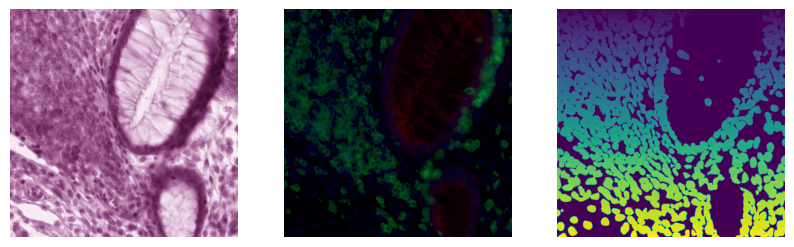

In [25]:
idx = np.random.randint(len(train_image_paths))

image_path = train_image_paths[idx]
label_path = train_label_paths[idx]
mask_path = train_mask_path[idx]

image_he = np.asarray(Image.open(image_path))
image_if = np.asarray(Image.open(label_path))
image_nuclei = np.asarray(Image.open(mask_path))

fig, axis = plt.subplots(1, 3, figsize=(10, 20))
axis[0].imshow(image_he)
axis[0].axis("off")
axis[1].imshow(image_if)
axis[1].axis("off")
axis[2].imshow(image_nuclei)
axis[2].axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

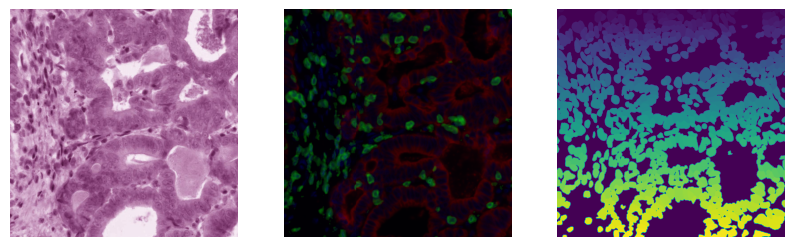

In [30]:
idx = np.random.randint(len(val_image_paths))

image_path = val_image_paths[idx]
label_path = val_label_paths[idx]
mask_path = val_mask_path[idx]

image_he = np.asarray(Image.open(image_path))
image_if = np.asarray(Image.open(label_path))
image_nuclei = np.asarray(Image.open(mask_path))

fig, axis = plt.subplots(1, 3, figsize=(10, 20))
axis[0].imshow(image_he)
axis[0].axis("off")
axis[1].imshow(image_if)
axis[1].axis("off")
axis[2].imshow(image_nuclei)
axis[2].axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

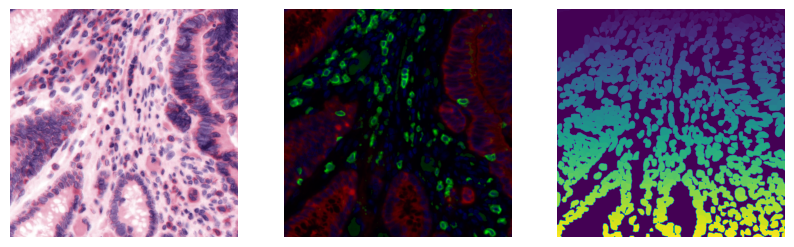

In [35]:
idx = np.random.randint(len(test_image_paths))

image_path = test_image_paths[idx]
label_path = test_label_paths[idx]
mask_path = test_mask_path[idx]

image_he = np.asarray(Image.open(image_path))
image_if = np.asarray(Image.open(label_path))
image_nuclei = np.asarray(Image.open(mask_path))

fig, axis = plt.subplots(1, 3, figsize=(10, 20))
axis[0].imshow(image_he)
axis[0].axis("off")
axis[1].imshow(image_if)
axis[1].axis("off")
axis[2].imshow(image_nuclei)
axis[2].axis("off")

## Single Cell data extraction

In [41]:
n_channels = np.asarray(Image.open(train_label_paths[0])).shape[-1]
num_workers = os.cpu_count() - 1

In [ ]:
train_csv_dir = (Path(DATASET_DIR) / "train/csv")
train_csv_dir.mkdir(exist_ok=True)

val_csv_dir = (Path(DATASET_DIR) / "val/csv")
val_csv_dir.mkdir(exist_ok=True)

test_csv_dir = (Path(DATASET_DIR) / "test/csv")
test_csv_dir.mkdir(exist_ok=True)

In [ ]:
properties = ['label', 'area', 'intensity_image', 'centroid']


if __name__ == "__main__":
    for phase in ["train", "val", "test"]:
        if phase == "train":
            phase_dataframe = train_dataframe
            phase_dir = train_csv_dir
        elif phase == "val":
            phase_dataframe = val_dataframe
            phase_dir = val_csv_dir
        elif phase == "test":
            phase_dataframe = test_dataframe
            phase_dir = test_csv_dir

        dataset = TileImg2ImgSlideDataset(
            phase_dataframe, return_nuclei=True)
        dataloader = DataLoader(dataset, shuffle=False, drop_last=False,
                                batch_size=1, num_workers=num_workers)

        for batch in dataloader:
            image_if = np.uint8(batch["target"][0].permute((1, 2, 0)).numpy())
            image_nuclei = np.int32(batch["nuclei"][0].numpy())
            props = regionprops_table(
                image_nuclei,
                intensity_image=image_if,
                properties=properties
            )
            df_roi = pd.DataFrame(props)
            if len(df_roi) == 0:
                continue
            df_roi['intensity_sum'] = df_roi['intensity_image'].apply(lambda x: np.mean(x, axis=(0, 1)))
            df_roi = df_roi.drop(columns=['intensity_image'])
            intensity_df = df_roi["intensity_sum"].apply(pd.Series)
            intensity_df.columns = CHANNEL_NAMES
            df_roi = pd.concat([df_roi.drop(columns=["intensity_sum"]), intensity_df], axis=1)
            tile_name = batch["tile_name"][0]
            df_roi.rename(columns={'centroid-0': 'Y_centroid', 'centroid-1': 'X_centroid'}, inplace=True)
            df_roi["X_centroid"] = df_roi["X_centroid"].astype(np.int32)
            df_roi["Y_centroid"] = df_roi["Y_centroid"].astype(np.int32)
            df_roi["area"] = df_roi["area"].astype(np.int32)
            df_path = str(Path(phase_dir) / f"{tile_name}.csv")
            df_roi.to_csv(df_path, index=False)

In [139]:
props = regionprops_table(
                np.zeros_like(image_nuclei),
                intensity_image=image_if,
                properties=properties
            )

In [ ]:
train_dataframe["nuclei_csv_path"] = train_dataframe["image_path"].apply(lambda x: str(Path(train_csv_dir) / (Path(x).name + ".csv")))
val_dataframe["nuclei_csv_path"] = val_dataframe["image_path"].apply(lambda x: str(Path(val_csv_dir) / (Path(x).name + ".csv")))
test_dataframe["nuclei_csv_path"] = test_dataframe["image_path"].apply(lambda x: str(Path(test_csv_dir) / (Path(x).name + ".csv")))


slide_dataframe = pd.concat([train_dataframe, val_dataframe, test_dataframe], ignore_index=True)
slide_dataframe = slide_dataframe.drop(columns=["image_path", "target_path", "nuclei_path"])

In [ ]:
train_dataframe.to_csv(str(Path(OUTPUT_DATAFRAME_DIR) / "train_dataframe_hemit.csv"), index=False)
val_dataframe.to_csv(str(Path(OUTPUT_DATAFRAME_DIR) / "val_dataframe_hemit.csv"), index=False)
test_dataframe.to_csv(str(Path(OUTPUT_DATAFRAME_DIR) / "test_dataframe_hemit.csv"), index=False)

slide_dataframe.to_csv(str(Path(OUTPUT_DATAFRAME_DIR) / "slide_dataframe_hemit.csv"), index=False)

,in_slide_name,image_path,target_path,nuclei_path,nuclei_csv_path
0,"[10358,37400]_patch_0_0.tif",/root/workdir/HEMIT_dataset/train/input/[10358...,/root/workdir/HEMIT_dataset/train/label/[10358...,"/root/workdir/HEMIT_dataset/train/mask/[10358,...","../../HEMIT_toy/train/csv/[10358,37400]_patch_..."
1,"[10358,37400]_patch_0_1.tif",/root/workdir/HEMIT_dataset/train/input/[10358...,/root/workdir/HEMIT_dataset/train/label/[10358...,"/root/workdir/HEMIT_dataset/train/mask/[10358,...","../../HEMIT_toy/train/csv/[10358,37400]_patch_..."
2,"[10358,37400]_patch_0_2.tif",/root/workdir/HEMIT_dataset/train/input/[10358...,/root/workdir/HEMIT_dataset/train/label/[10358...,"/root/workdir/HEMIT_dataset/train/mask/[10358,...","../../HEMIT_toy/train/csv/[10358,37400]_patch_..."
3,"[10358,37400]_patch_0_3.tif",/root/workdir/HEMIT_dataset/train/input/[10358...,/root/workdir/HEMIT_dataset/train/label/[10358...,"/root/workdir/HEMIT_dataset/train/mask/[10358,...","../../HEMIT_toy/train/csv/[10358,37400]_patch_..."
4,"[10358,37400]_patch_0_4.tif",/root/workdir/HEMIT_dataset/train/input/[10358...,/root/workdir/HEMIT_dataset/train/label/[10358...,"/root/workdir/HEMIT_dataset/train/mask/[10358,...","../../HEMIT_toy/train/csv/[10358,37400]_patch_..."
...,...,...,...,...,...
3712,"[9117,42089]_patch_6_4.tif","/root/workdir/HEMIT_dataset/train/input/[9117,...","/root/workdir/HEMIT_dataset/train/label/[9117,...","/root/workdir/HEMIT_dataset/train/mask/[9117,4...","../../HEMIT_toy/train/csv/[9117,42089]_patch_6..."
3713,"[9117,42089]_patch_6_5.tif","/root/workdir/HEMIT_dataset/train/input/[9117,...","/root/workdir/HEMIT_dataset/train/label/[9117,...","/root/workdir/HEMIT_dataset/train/mask/[9117,4...","../../HEMIT_toy/train/csv/[9117,42089]_patch_6..."
3714,"[9117,42089]_patch_6_6.tif","/root/workdir/HEMIT_dataset/train/input/[9117,...","/root/workdir/HEMIT_dataset/train/label/[9117,...","/root/workdir/HEMIT_dataset/train/mask/[9117,4...","../../HEMIT_toy/train/csv/[9117,42089]_patch_6..."
3715,"[9117,42089]_patch_6_7.tif","/root/workdir/HEMIT_dataset/train/input/[9117,...","/root/workdir/HEMIT_dataset/train/label/[9117,...","/root/workdir/HEMIT_dataset/train/mask/[9117,4...","../../HEMIT_toy/train/csv/[9117,42089]_patch_6..."


## GMM clustering

In [5]:
def get_threshold_gmm(df_all, marker_name, log_norm=False, max_cells=None):
    gmm = GaussianMixture(n_components=2, random_state=42)
    data = df_all[df_all[marker_name] > 0][[marker_name]]
    if max_cells:
        n_sample = min(max_cells, len(data))
        data = data.sample(n_sample)
    if log_norm:
        shift_log = 1
        gmm.fit(np.log(data + shift_log))
    else:
        gmm.fit(data)
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    # Find the threshold: intersection of two Gaussians
    mean1, mean2 = sorted(means)
    std1, std2 = np.sqrt(sorted(variances))

    threshold = (mean1 * std2**2 - mean2 * std1**2 + std1 * std2 * \
        np.sqrt((mean1 - mean2)**2 + 2 * (std2**2 - std1**2) * np.log(std2 / std1))) / (std2**2 - std1**2)
    if log_norm:
        threshold = (np.exp(threshold) - shift_log)

    plt.hist(data, bins=255, density=True, alpha=0.5, label="Data Distribution")
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f"Threshold: {threshold:.2f}")
    plt.legend()
    plt.title("Bi-Gaussian Distribution and Thresholding")
    plt.show()
    return gmm, threshold

In [7]:
df_all = []

for nuclei_csv_path in tqdm(slide_dataframe["nuclei_csv_path"].tolist()):
    try:
        df_roi = pd.read_csv(nuclei_csv_path)
        df_all.append(df_roi)
    except FileNotFoundError:
        pass # no cells detected for this tile

df_all = pd.concat(df_all, ignore_index=True)

100%|██████████| 5292/5292 [00:04<00:00, 1075.90it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Pan-CK


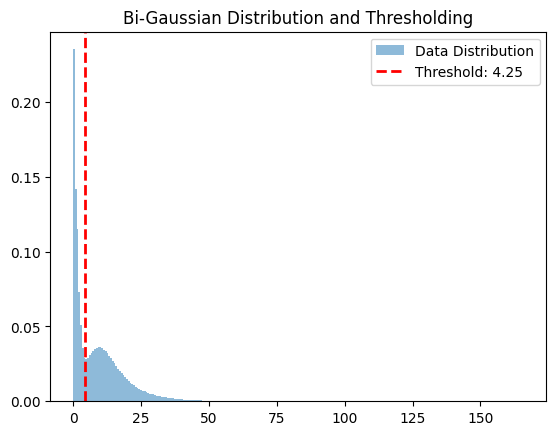

 33%|███▎      | 1/3 [00:02<00:05,  2.85s/it]

CD3


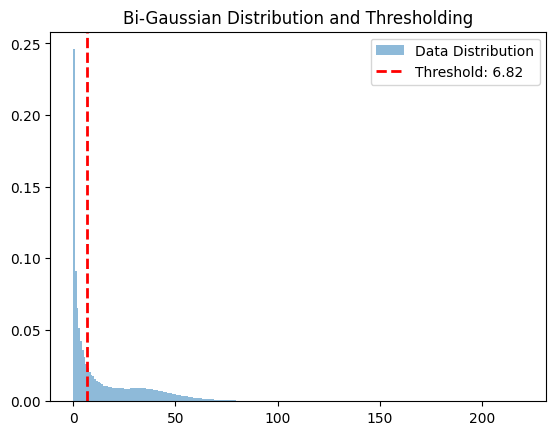

 67%|██████▋   | 2/3 [00:04<00:02,  2.31s/it]

DAPI


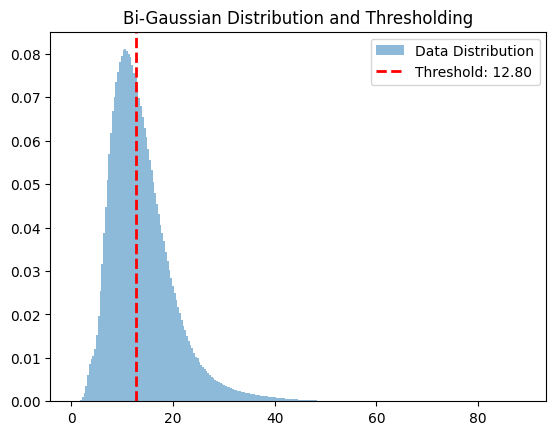

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


In [11]:
threshold_dict = {}
for channel_name in tqdm(CHANNEL_NAMES):
    print(channel_name)
    gmm, threshold = get_threshold_gmm(df_all, channel_name, log_norm=True, max_cells=None)
    threshold_dict[channel_name] = threshold

In [ ]:
df_all = []

for nuclei_csv_path in tqdm(slide_dataframe["nuclei_csv_path"].tolist()):
    try:
        df_roi = pd.read_csv(nuclei_csv_path)
        df_roi["Pan-CK_pos"] = df_roi["Pan-CK"] > threshold_dict["Pan-CK"]
        df_roi["CD3_pos"] = df_roi["CD3"] > threshold_dict["CD3"]
        df_roi.to_csv(nuclei_csv_path, index=False)
    except FileNotFoundError:
        pass # no cells detected for this tile

100%|██████████| 5292/5292 [00:06<00:00, 792.81it/s]
